## **Analysis**
**Author**: Chiara Virzì

This notebook extracts key parameters from the Hα emission line in YSO spectra, using reduced 1D FITS files. It calculates the 10% width, FWZI, wing velocities, and estimates mass accretion rates based on empirical formulas. The method focuses on a user-defined wavelength range and follows a simple, automated approach suitable for multiple spect.

The used libraries are the following:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

In [ ]:
# Speed of light in km/s
c = 3e5

# Hα rest wavelength in Ångströms
lambda_Ha = 6562.8

# User-defined wavelength range for the FWZI estimation
range_min = 6553.05
range_max = 6573.00

base_folder = 'best'
skysub_folder = os.path.join(base_folder, 'skysub')
file_path = os.path.join(skysub_folder, 'best_skysub.fits')

with fits.open(file_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    crval = header['CRVAL1']
    cdelt = header['CDELT1']
    crpix = header['CRPIX1']
    npix = header['NAXIS1']

#Build the wavelength array from FITS WCS keywords 
wavelength = crval + (np.arange(npix) - (crpix - 1)) * cdelt
flux = data

# Mask region around the Hα line
mask = (wavelength >= range_min) & (wavelength <= range_max)
w = wavelength[mask]
f = flux[mask]

#Find the true emission peak in the masked region 
peak_idx = np.argmax(f)
lambda_peak = w[peak_idx]
peak_flux = f[peak_idx]

#Estimate continuum from edges of the masked region
continuum = np.median(np.concatenate([f[:10], f[-10:]]))
level10 = continuum + 0.10 * (peak_flux - continuum)

#Find 10% intensity crossing points on both sides of the peak
left_inds = np.where(f[:peak_idx] <= level10)[0]
right_inds = np.where(f[peak_idx:] <= level10)[0] + peak_idx

if len(left_inds) == 0 or len(right_inds) == 0:
    raise ValueError("Cannot find 10% width boundaries")

i_blue10 = left_inds[-1]
i_red10 = right_inds[0]

lambda_blue10 = w[i_blue10]
lambda_red10 = w[i_red10]

# Compute 10% width (Bonito+2020 definition) 
width10_A = (range_max - lambda_red10) + (lambda_blue10 - range_min)
width10_kms = (width10_A / lambda_Ha) * c

# Compute FWZI as the full width of the user-defined region
fwzi_A = range_max - range_min

# Compute radial velocities of the wings 
v_blue = -c * (lambda_Ha - range_min) / lambda_Ha
v_red  =  c * (range_max - lambda_Ha) / lambda_Ha

# Estimate mass accretion rates using two methods
log_Macc_venuti = -12.89 + 9.7e-3 * width10_kms         # Natta 2004
log_Macc_custom = -14.823 + 0.406 * fwzi_A              # Custom calibration

#  Output results 
print(f"Hα 10% width: {width10_kms:.2f} km/s")
print(f"FWZI: {fwzi_A:.2f} Å")
print(f"v_blue: {v_blue:.0f} km/s")
print(f"v_red: {v_red:.0f} km/s")
print(f"log Macc (Venuti+2014): {log_Macc_Natta:.2f}")
print(f"log Macc (custom): {log_Macc_custom:.2f}")

This section analyzes the relationship between the full width at zero intensity (FWZI) of the Hα emission line and the logarithm of the mass accretion rate (log Ṁₐcc) in a set of pre-existing data. The data is loaded from an Excel file containing FWZI measurements and corresponding accretion rates. A simple linear regression is applied to the filtered dataset (excluding points with log Ṁₐcc < –10) to investigate whether a linear trend can describe the correlation between these parameters. This approach can help define a custom empirical calibration for estimating mass accretion rates from FWZI in other YSO spectra. The result is visualized through a scatter plot and best-fit line, useful for comparing with theoretical or literature-based calibrations.

Regression line: y = 0.406x + -14.823


C:\Users\chiar\AppData\Local\Temp\ipykernel_7896\2680337651.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


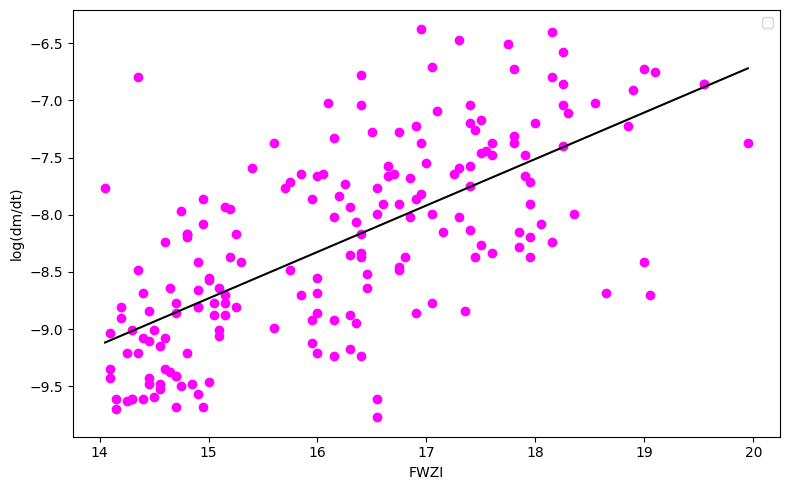

In [ ]:
# Load the Excel file
file_path = 'natta.xlsx'
df = pd.read_excel(file_path)

# Select the 2nd and 3rd columns for x and y values
x = df.iloc[:, 1]
y = df.iloc[:, 2]

mask = y >= -10 #limit the y value
x = x[mask]
y = y[mask]

# Scatter plot of the filtered data
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color='magenta')

# Perform a linear fit (regression) on the data
slope, intercept = np.polyfit(x, y, 1)
print(f"Regression line: y = {slope:.3f}x + {intercept:.3f}")

# Generate x-values for the fitted line
x_fit = np.linspace(x.min(), x.max(), 100)
y_fit = slope * x_fit + intercept

# Plot the best-fit line
plt.plot(x_fit, y_fit, color='black')

plt.xlabel("FWZI")
plt.ylabel("log(dm/dt)")
plt.grid(False)
plt.tight_layout()
folder = 'immaginireport'  
diff_plot_filename = os.path.join(folder, 'natta.png')
#plt.savefig(diff_plot_filename)
plt.show()

## **Mass accretion**
This notebook analyzes the relationship between the mass accretion rate and the Hα line profile width in a sample of young stellar objects. Specifically, it uses data from Natta et al.2004  containing the logarithm of the mass accretion rate (log(Ṁ)), calculated using the Hα 10% width method.

To investigate this relation further, we compare log(Ṁ) with the Full Width at Zero Intensity (FWZI) of the Hα emission line, measured from spectra of the "good" quality subset of objects. By performing a linear regression between FWZI and log(Ṁ), we aim to assess whether broader Hα wings correlate with higher accretion activity.